In [124]:
from csoundengine.offline import OfflineEngine
e = OfflineEngine(outfile="pitchtrack.wav")
e.compile('''
opcode nearest, k, kkkk
  k0, k1, k2, k3 xin
  kout = abs(k1 - k0) < abs(k2 - k0) ? k1 : k2
  kout = abs(kout - k0) < (k3 - k0) ? kout : k3
  xout kout
endop

instr pitchtrack
  isndtable, iouttable passign 4
  kfreq init 100
  kfreqp init 100
  
  achannels[] = loscilx(1, 1, isndtable, 4, 1)
  a0 = achannels[0]
  icutoff = 4000
  afeat = butlp(a0, icutoff)
  afeat = butlp(afeat, icutoff)
  krms = rms(a0, 20)
  
  ; asig, kd [, kloopf, kloopq, klf, khf, kthresh]
  fsig = pvsanal(afeat, 1024, 128, 1024, 0)
  fsig2 = pvsanal(a0, 1024, 128, 1024, 0)
  kflatness = pow(pvsflatness:k(fsig2, 50, 10000), 1.5)
  kpeakyness = pvsmagsumn(fsig2, 30, 40) / max(0.0000001, pvsmagsum(fsig2))
  knoisyness = sqrt(kflatness*kflatness + pow(1-kpeakyness, 2))
  kfreq1, kamp pvspitch fsig, ampdb(-45)
  kfreq2, kamp pvspitch fsig2, ampdb(-45)
  kfreq3, kamp pvspitch fsig, ampdb(-35)
  
  ksound = schmitt(krms, ampdb(-50), ampdb(-60))
  ; ksound = 1
  knoisegate = schmitt(knoisyness, 0.5, 0.4) * ksound
  
  if knoisegate < 0.5 then
    kfreqpred = (kfreq - kfreqp) * 1 + kfreq
    kfreq = nearest(kfreqpred, kfreq1, kfreq2, kfreq3)
  endif
  
  ; kfreq = kfreq1
  kfreq = lagud(kfreq, 0.01, 0.05)
      
  kcount = eventcycles()
  kidx = kcount * 3 + 1
  ktime = eventtime()
  knoisegate *= kfreq > 0 ? 1 : 0
  
  tabw ktime, kidx, iouttable
  tabw kfreq, kidx+1, iouttable
  tabw knoisegate, kidx+2, iouttable
  tabw kcount, 0, iouttable

  aenv = lagud:a(interp(1 - knoisegate), 0.03, 0.01)
  aenv *= aenv
  asig = buzz(aenv, kfreq, 7, -1)
  outch 1, delay(a0, 1024 / sr)
  outch 2, asig * interp(kamp) * 1.2
endin
''')

sndtab = e.readSoundfile("../snd/voiceover-fragment-48k.flac")
# sndtab = e.readSoundfile("../snd/colours-german-male.flac")
sndinfo = e.tableInfo(sndtab)
duration = sndinfo.duration
numcycles = int(duration * e.sr / e.ksmps)
numcols = 3  # The instrument saves 3 columns of information per cycle (times, freqs, locks)
freqtab = e.makeEmptyTable((numcycles + 100) * numcols)
e.sched('pitchtrack', 0, duration + 0.1, sndtab, freqtab)
e.perform()

# Now retrieve information, accesses the table created before
outarr = e.tableData(freqtab)
# The first index keeps the number of cycles analyzed
datalen = int(outarr[0])
times = outarr[1:1+datalen*numcols:numcols]
freqs = outarr[2:1+datalen*numcols:numcols]
gate = outarr[3:1+datalen*numcols:numcols]



--Csound version 7.0 (double samples) Oct 28 2025
[commit: 15afda0ba81a895a4e87ac3ef5fe476702b072bf]
using libsndfile-1.2.2
sr = 44100.0, kr = 689.062, ksmps = 64
0dBFS level = 1.0, A4 tuning = 440.0
audio buffered in 256 sample-frame blocks
writing 1024-byte blks of shorts to /home/em/dev/python/csoundengine/notebooks/test/pitchtrack.wav (WAV)
SECTION 1:


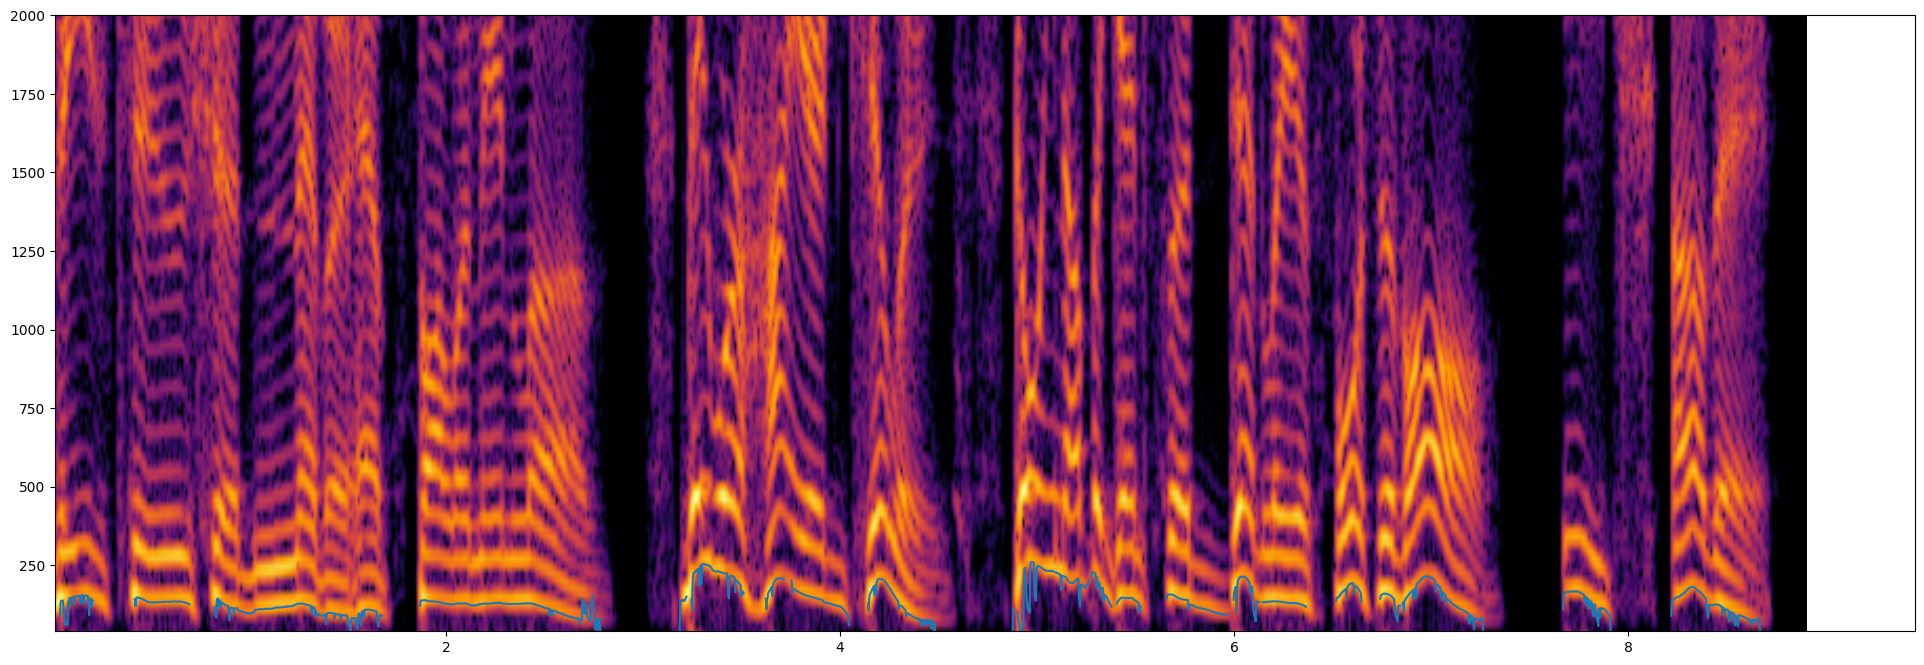

In [125]:
import matplotlib.pyplot as plt
import csoundengine.plotting

samples = e.tableData(sndtab)
sr = e.tableInfo(sndtab).sr

fig, ax = plt.subplots(1, 1, figsize=(24, 8))
csoundengine.plotting.plotSpectrogram(samples, sr, axes=ax, maxfreq=2000)
freqs2 = freqs * (gate < 0.5)

freqs2[freqs2 > 1500] = 0
freqs2[freqs2 == 0] = float('nan')
ax.plot(times - 0.02, freqs2)


resetting Csound instance
		   overall amps:  0.78928  0.52371
	   overall samples out of range:        0        0
0 errors in performance
512 1024 sample blks of shorts written to /home/em/dev/python/csoundengine/notebooks/test/pitchtrack.wav (WAV)


RenderJob(outfile='/home/em/dev/python/csoundengine/notebooks/test/pitchtrack.wav', samplerate=44100, encoding='float32', starttime=0.0, endtime=0.0, process=None)
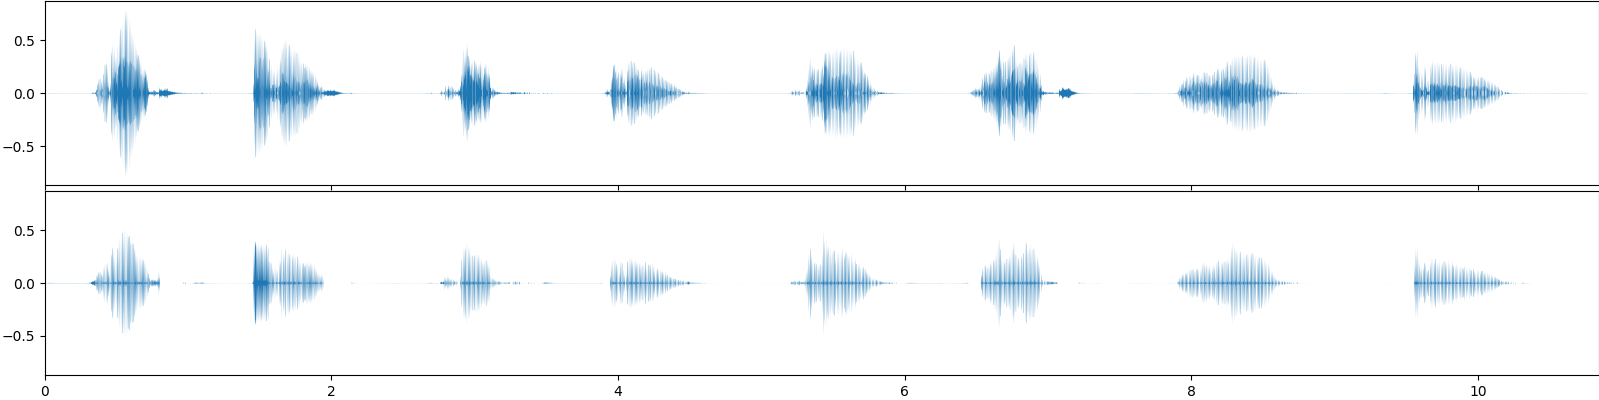

In [113]:
job = e.stop()
job